In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [2]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter

lemmatizer = WordNetLemmatizer()

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [ ]:
# Opening JSON file
file_path = '/content/drive/MyDrive/upGrad/Projects/NLP/Ticket Classification/complaints.json'

# Opening JSON file
with open(file_path, 'r') as f:
    # Load the JSON data into a dictionary
    data = json.load(f)

# returns JSON object as  a dictionary
complaints=pd.json_normalize(data)
complaints

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78308,complaint-public-v2,complaint,3105617,0.0,None,08857,3105617,Closing an account,2018-12-20T12:00:00-05:00,NJ,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2018-12-21T12:00:00-05:00,None,Checking account,Yes,,Funds not received from closed account,Consent not provided
78309,complaint-public-v2,complaint,3091984,0.0,None,934XX,3091984,"Other features, terms, or problems",2018-12-05T12:00:00-05:00,CA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Other problem,Consent provided
78310,complaint-public-v2,complaint,3133355,0.0,None,923XX,3133355,Problem with a lender or other company chargin...,2019-01-25T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-01-25T12:00:00-05:00,None,Checking account,Yes,I am not familiar with XXXX pay and did not un...,Transaction was not authorized,Consent provided
78311,complaint-public-v2,complaint,3110963,0.0,None,None,3110963,"Other features, terms, or problems",2018-12-27T12:00:00-05:00,PA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-27T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I have had flawless credit for 30 yrs. I've ha...,Problem with balance transfer,Consent provided


## Data preparation

In [ ]:
# Inspect the dataframe to understand the given data.
complaints.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [ ]:
complaints.shape

(78313, 22)

In [ ]:
complaints.describe()

,_score
count,78313.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [ ]:
#print the column names
for col in complaints.columns:
  print(col)

_index
_type
_id
_score
_source.tags
_source.zip_code
_source.complaint_id
_source.issue
_source.date_received
_source.state
_source.consumer_disputed
_source.product
_source.company_response
_source.company
_source.submitted_via
_source.date_sent_to_company
_source.company_public_response
_source.sub_product
_source.timely
_source.complaint_what_happened
_source.sub_issue
_source.consumer_consent_provided


In [ ]:
#Assign new column names
new_column_names = [column.replace('_', '').replace('.', '').replace('source', '') for column in complaints.columns]
complaints.columns = new_column_names
complaints

,index,type,id,score,tags,zipcode,complaintid,issue,datereceived,state,...,companyresponse,company,submittedvia,datesenttocompany,companypublicresponse,subproduct,timely,complaintwhathappened,subissue,consumerconsentprovided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78308,complaint-public-v2,complaint,3105617,0.0,None,08857,3105617,Closing an account,2018-12-20T12:00:00-05:00,NJ,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2018-12-21T12:00:00-05:00,None,Checking account,Yes,,Funds not received from closed account,Consent not provided
78309,complaint-public-v2,complaint,3091984,0.0,None,934XX,3091984,"Other features, terms, or problems",2018-12-05T12:00:00-05:00,CA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Other problem,Consent provided
78310,complaint-public-v2,complaint,3133355,0.0,None,923XX,3133355,Problem with a lender or other company chargin...,2019-01-25T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-01-25T12:00:00-05:00,None,Checking account,Yes,I am not familiar with XXXX pay and did not un...,Transaction was not authorized,Consent provided
78311,complaint-public-v2,complaint,3110963,0.0,None,None,3110963,"Other features, terms, or problems",2018-12-27T12:00:00-05:00,PA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-27T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I have had flawless credit for 30 yrs. I've ha...,Problem with balance transfer,Consent provided


In [ ]:
for col in complaints.columns:
  print(col)

index
type
id
score
tags
zipcode
complaintid
issue
datereceived
state
consumerdisputed
product
companyresponse
company
submittedvia
datesenttocompany
companypublicresponse
subproduct
timely
complaintwhathappened
subissue
consumerconsentprovided


In [ ]:
complaints.rename(columns = {'complaintwhathappened' : 'complaints'}, inplace=True)
complaints

,index,type,id,score,tags,zipcode,complaintid,issue,datereceived,state,...,companyresponse,company,submittedvia,datesenttocompany,companypublicresponse,subproduct,timely,complaints,subissue,consumerconsentprovided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78308,complaint-public-v2,complaint,3105617,0.0,None,08857,3105617,Closing an account,2018-12-20T12:00:00-05:00,NJ,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2018-12-21T12:00:00-05:00,None,Checking account,Yes,,Funds not received from closed account,Consent not provided
78309,complaint-public-v2,complaint,3091984,0.0,None,934XX,3091984,"Other features, terms, or problems",2018-12-05T12:00:00-05:00,CA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Other problem,Consent provided
78310,complaint-public-v2,complaint,3133355,0.0,None,923XX,3133355,Problem with a lender or other company chargin...,2019-01-25T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-01-25T12:00:00-05:00,None,Checking account,Yes,I am not familiar with XXXX pay and did not un...,Transaction was not authorized,Consent provided
78311,complaint-public-v2,complaint,3110963,0.0,None,None,3110963,"Other features, terms, or problems",2018-12-27T12:00:00-05:00,PA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-27T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I have had flawless credit for 30 yrs. I've ha...,Problem with balance transfer,Consent provided


In [ ]:
#Assign nan in place of blanks in the complaints column
complaints['complaints'] = complaints['complaints'].replace('', np.nan)
complaints.isna().sum()

index                          0
type                           0
id                             0
score                          0
tags                       67413
zipcode                     6757
complaintid                    0
issue                          0
datereceived                   0
state                       1991
consumerdisputed               0
product                        0
companyresponse                0
company                        0
submittedvia                   0
datesenttocompany              0
companypublicresponse      78309
subproduct                 10571
timely                         0
complaints                 57241
subissue                   46297
consumerconsentprovided     1008
dtype: int64

In [ ]:
#Remove all rows where complaints column is nan
complaints = complaints.dropna(subset=['complaints'])
complaints.isna().sum()

index                          0
type                           0
id                             0
score                          0
tags                       17256
zipcode                     4645
complaintid                    0
issue                          0
datereceived                   0
state                        143
consumerdisputed               0
product                        0
companyresponse                0
company                        0
submittedvia                   0
datesenttocompany              0
companypublicresponse      21070
subproduct                  2109
timely                         0
complaints                     0
subissue                    8176
consumerconsentprovided        0
dtype: int64

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [ ]:
# Write your function here to clean the text and remove all the unnecessary elements.
def preprocess_text(text):
    text = text.lower()  # Make the text lowercase
    text = re.sub(r'\[.*?\]', '', text) # Remove text in square brackets
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = ' '.join(word for word in text.split() if not any(char.isdigit() for char in word))  # Remove words containing numbers

    return text

In [ ]:
#Write your function to Lemmatize the texts
def lemmatize_text(text):
    # Tokenize the text and apply lemmatization to each token
    tokens = nltk.word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join the lemmatized tokens back into a single string
    lemmatized_text = ' '.join(lemmatized_tokens)

    return lemmatized_text

In [ ]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = pd.DataFrame(complaints['complaints'])
df_clean['complaints'] = df_clean['complaints'].apply(preprocess_text)
df_clean['lemm_complaints'] = df_clean['complaints'].apply(lemmatize_text)

In [ ]:
df_clean

,complaints,lemm_complaints
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket i c...,on while trying to book a xxxx xxxx ticket i c...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...
...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...
78311,i have had flawless credit for yrs ive had cha...,i have had flawless credit for yr ive had chas...


In [ ]:
#Write your function to extract the POS tags

def keep_nouns(text):
  words = word_tokenize(text)
  tagged_words = pos_tag(words)
  nouns = [word for word, tag in tagged_words if tag.startswith('NN')]
  return ' '.join(nouns)

df_clean["complaint_POS_removed"] =  df_clean['lemm_complaints'].apply(keep_nouns)#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


In [ ]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.reset_index(inplace=True, drop=True)
df_clean

,complaints,lemm_complaints,complaint_POS_removed
0,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name xxxx stop bank cardmember service...
1,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...
2,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...
3,on while trying to book a xxxx xxxx ticket i c...,on while trying to book a xxxx xxxx ticket i c...,book xxxx ticket i offer ticket card i informa...
4,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...
...,...,...,...
21067,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade wa solicitation cre...
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,xxxxxxxx i chas xxxx visa credit card provider...
21069,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,i pay risk consumer i bank app i chase year mo...
21070,i have had flawless credit for yrs ive had cha...,i have had flawless credit for yr ive had chas...,i credit credit card chase freedom xxxx proble...


Checkpoint 1

In [ ]:
df_clean.to_pickle('/content/drive/MyDrive/upGrad/Projects/NLP/Ticket Classification/df_clean_ckpt1.pk1')

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




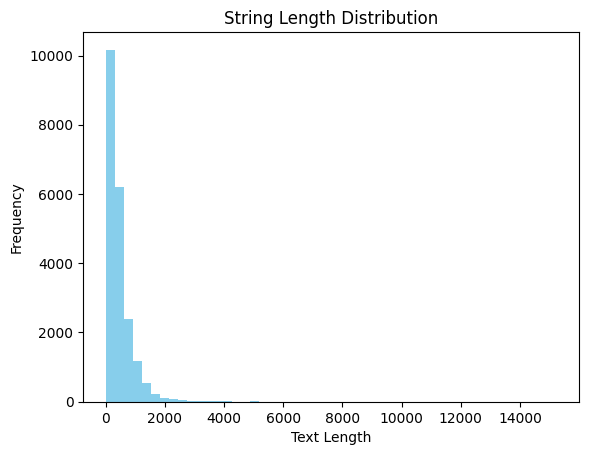

In [ ]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean['clens'] = df_clean['complaint_POS_removed'].apply(len)

# Create a histogram with a specified number of bins
plt.hist(df_clean['clens'], bins=50, color='skyblue')  # You can adjust the number of bins as needed
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('String Length Distribution')

# Show the histogram
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

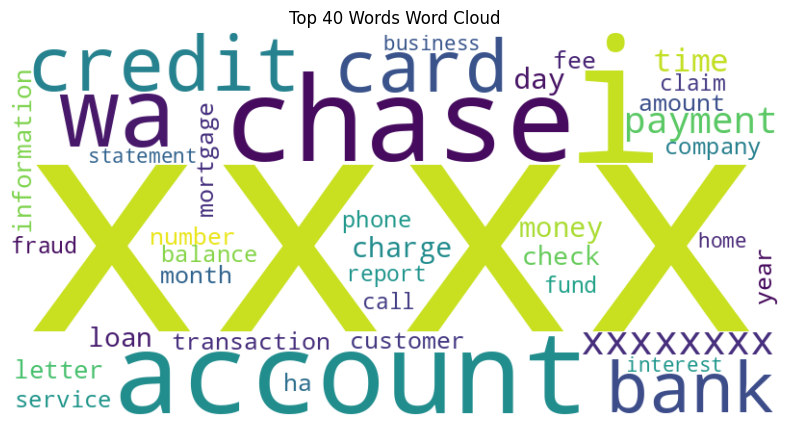

In [ ]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
all_text = ' '.join(df_clean['complaint_POS_removed'])
words = all_text.split()
word_freq = Counter(words)
top_words = word_freq.most_common(40)

# Create a dictionary of the top words and their frequencies
top_words_dict = dict(top_words)

# Create a WordCloud object for the top 40 words
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words_dict)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 40 Words Word Cloud')
plt.show()

In [ ]:
#Removing -PRON- from the text corpus
def rem_pron(text):
  words = word_tokenize(text)
  tagged_words = pos_tag(words)
  nouns = [word for word, tag in tagged_words if tag != 'NNP']
  return ' '.join(nouns)

df_clean['complaint_clean'] = df_clean['complaint_POS_removed'].apply(rem_pron)

In [ ]:
df_clean

,complaints,lemm_complaints,complaint_POS_removed,clens,complaint_clean
0,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name xxxx stop bank cardmember service...,185,morning name stop bank cardmember service debt...
1,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...,103,i card agent upgrade date agent wa information...
2,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...,70,card wa application identity consent service c...
3,on while trying to book a xxxx xxxx ticket i c...,on while trying to book a xxxx xxxx ticket i c...,book xxxx ticket i offer ticket card i informa...,436,book xxxx ticket i offer ticket card i informa...
4,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...,175,son deposit chase account fund chase bank acco...
...,...,...,...,...,...
21067,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade wa solicitation cre...,245,chase card customer decade wa solicitation cre...
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,xxxxxxxx i chas xxxx visa credit card provider...,703,xxxxxxxx i chas xxxx visa credit card provider...
21069,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,i pay risk consumer i bank app i chase year mo...,733,i pay risk consumer i bank app i chase year mo...
21070,i have had flawless credit for yrs ive had cha...,i have had flawless credit for yr ive had chas...,i credit credit card chase freedom xxxx proble...,529,i credit credit card chase freedom problem bal...


Checkpoint 2

In [ ]:
df_clean.to_pickle('/content/drive/MyDrive/upGrad/Projects/NLP/Ticket Classification/df_clean_ckpt2.pk1')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [ ]:
df_clean_grams = pd.DataFrame(df_clean['complaint_clean'])
df_clean_grams['complaints_tok'] = df_clean['complaint_clean'].apply(nltk.word_tokenize)

In [ ]:
df_clean_grams

,complaint_clean,complaints_tok
0,morning name stop bank cardmember service debt...,"[morning, name, stop, bank, cardmember, servic..."
1,i card agent upgrade date agent wa information...,"[i, card, agent, upgrade, date, agent, wa, inf..."
2,card wa application identity consent service c...,"[card, wa, application, identity, consent, ser..."
3,book xxxx ticket i offer ticket card i informa...,"[book, xxxx, ticket, i, offer, ticket, card, i..."
4,son deposit chase account fund chase bank acco...,"[son, deposit, chase, account, fund, chase, ba..."
...,...,...
21067,chase card customer decade wa solicitation cre...,"[chase, card, customer, decade, wa, solicitati..."
21068,xxxxxxxx i chas xxxx visa credit card provider...,"[xxxxxxxx, i, chas, xxxx, visa, credit, card, ..."
21069,i pay risk consumer i bank app i chase year mo...,"[i, pay, risk, consumer, i, bank, app, i, chas..."
21070,i credit credit card chase freedom problem bal...,"[i, credit, credit, card, chase, freedom, prob..."


In [ ]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
df_clean_grams['Unigrams'] = df_clean_grams['complaint_clean'].apply(lambda x: x)
all_unigrams = [word for sublist in df_clean_grams['Unigrams'] for word in sublist]
unigram_freq = Counter(all_unigrams)
top_unigrams = unigram_freq.most_common(30)
top_unigrams_df = pd.DataFrame(top_unigrams, columns=['Unigram', 'Frequency'])

In [ ]:
#Print the top 10 words in the unigram frequency
print("Top 10 Unigrams:")
top_unigrams_df.head(10)


Top 10 Unigrams:


,Unigram,Frequency
0,,1344099
1,e,859769
2,a,698172
3,t,609471
4,i,596521
5,n,569384
6,c,522280
7,r,511210
8,o,482162
9,s,361544


In [ ]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
df_clean_grams['Bigrams'] = df_clean_grams['complaint_clean'].apply(lambda x: list(nltk.bigrams(x)))
all_bigrams = [bigram for sublist in df_clean_grams['Bigrams'] for bigram in sublist]
bigram_freq = Counter(all_bigrams)
top_bigrams = bigram_freq.most_common(30)
top_bigrams_df = pd.DataFrame(top_bigrams, columns=['Bigram', 'Frequency'])


In [ ]:
#Print the top 10 words in the bigram frequency
print("Top 10 Bigrams:")
top_bigrams_df.head(10)


Top 10 Bigrams:


,Bigram,Frequency
0,"(e, )",284931
1,"(t, )",232832
2,"( , c)",231609
3,"( , i)",179880
4,"(n, t)",163267
5,"(x, x)",159624
6,"(o, n)",148073
7,"(i, )",140950
8,"(r, e)",134825
9,"(e, r)",125432


In [ ]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
df_clean_grams['Trigrams'] = df_clean_grams['complaint_clean'].apply(lambda x: list(nltk.trigrams(x)))
all_trigrams = [trigram for sublist in df_clean_grams['Trigrams'] for trigram in sublist]
trigram_freq = Counter(all_trigrams)
top_trigrams = trigram_freq.most_common(30)
top_trigrams_df = pd.DataFrame(top_trigrams, columns=['Trigram', 'Frequency'])

In [ ]:
#Print the top 10 words in the trigram frequency
print("Top 30 Trigrams:")
top_trigrams_df.head(10)

Top 30 Trigrams:


,Trigram,Frequency
0,"( , i, )",131714
1,"(n, t, )",127353
2,"(x, x, x)",119310
3,"(o, n, )",83698
4,"( , c, h)",78332
5,"(i, o, n)",76396
6,"(c, h, a)",75040
7,"(s, e, )",74641
8,"(t, i, o)",70043
9,"(e, r, )",68291


In [ ]:
top_unigrams_df.to_pickle('/content/drive/MyDrive/upGrad/Projects/NLP/Ticket Classification/unigrams.pk1')
top_bigrams_df.to_pickle('/content/drive/MyDrive/upGrad/Projects/NLP/Ticket Classification/bigrams.pk1')
top_trigrams_df.to_pickle('/content/drive/MyDrive/upGrad/Projects/NLP/Ticket Classification/trigrams.pk1')

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [ ]:
df_clean['complaint_clean'] = df_clean['complaint_clean'].str.replace('xxxx','')

In [ ]:
#All masked texts has been removed
df_clean

,complaints,lemm_complaints,complaint_POS_removed,clens,complaint_clean
0,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name xxxx stop bank cardmember service...,185,morning name stop bank cardmember service debt...
1,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...,103,i card agent upgrade date agent wa information...
2,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...,70,card wa application identity consent service c...
3,on while trying to book a xxxx xxxx ticket i c...,on while trying to book a xxxx xxxx ticket i c...,book xxxx ticket i offer ticket card i informa...,436,book ticket i offer ticket card i information...
4,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...,175,son deposit chase account fund chase bank acco...
...,...,...,...,...,...
21067,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade wa solicitation cre...,245,chase card customer decade wa solicitation cre...
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,xxxxxxxx i chas xxxx visa credit card provider...,703,i chas visa credit card provider claim purch...
21069,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,i pay risk consumer i bank app i chase year mo...,733,i pay risk consumer i bank app i chase year mo...
21070,i have had flawless credit for yrs ive had cha...,i have had flawless credit for yr ive had chas...,i credit credit card chase freedom xxxx proble...,529,i credit credit card chase freedom problem bal...


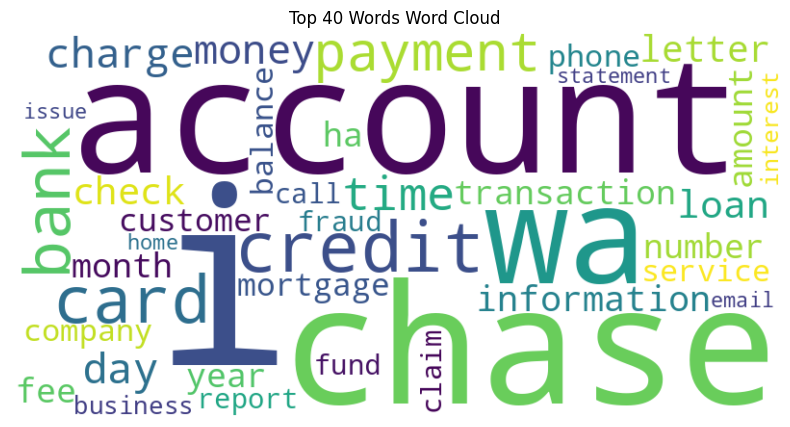

In [ ]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
all_text = ' '.join(df_clean['complaint_clean'])
words = all_text.split()
word_freq = Counter(words)
top_words = word_freq.most_common(40)

# Create a dictionary of the top words and their frequencies
top_words_dict = dict(top_words)

# Create a WordCloud object for the top 40 words
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words_dict)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 40 Words Word Cloud')
plt.show()

Checkpoint 3

In [ ]:
df_clean.to_pickle('/content/drive/MyDrive/upGrad/Projects/NLP/Ticket Classification/df_clean_ckpt3.pk1')

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [ ]:
#Write your code here to initialise the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [ ]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.

tfidf_matrix = tfidf_vectorizer.fit_transform(df_clean['complaint_clean'])
# Create a DataFrame to store the document-term matrix (DTM)
dtm = pd.DataFrame.sparse.from_spmatrix(tfidf_matrix, columns=tfidf_vectorizer.get_feature_names_out())

dtm

,aa,aaaratings,aarp,ab,abandonment,abatement,abbreviation,abd,abide,ability,...,yourselves,youth,youve,yr,ytd,zero,zilch,zip,zombie,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
dtm.to_pickle('/content/drive/MyDrive/upGrad/Projects/NLP/Ticket Classification/dtm.pk1')

In [ ]:
df_clean = pd.read_pickle('/content/drive/MyDrive/upGrad/Projects/NLP/Ticket Classification/df_clean_ckpt3.pk1')
dtm = pd.read_pickle('/content/drive/MyDrive/upGrad/Projects/NLP/Ticket Classification/dtm.pk1')

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [ ]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [ ]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5#write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=5, random_state=40)#write your code here

In [ ]:
nmf_model.fit(dtm)
print(len(dtm.columns))

7494


In [ ]:
#Print the Top15 words for each of the topics
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print()

n_top_words = 15
print_top_words(nmf_model, tfidf_vectorizer.get_feature_names_out(), n_top_words)

Topic #1:
account bank check money fund chase wa deposit branch day fee checking business number customer

Topic #2:
card credit chase balance account fee interest limit score year month wa point purchase offer

Topic #3:
payment loan mortgage chase month modification home interest wa time year rate balance amount property

Topic #4:
inquiry report credit bureau company information reporting identity debt score theft letter jpmcb application account

Topic #5:
charge transaction chase dispute claim wa fraud merchant letter phone information time number service call



In [ ]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
nmf_features = nmf_model.transform(tfidf_matrix)
complaint_topics = nmf_features.argmax(axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but NMF was fitted with feature names



In [ ]:
#Assign the best topic to each of the cmplaints in Topic Column

# nmf_df = pd.DataFrame(df_clean['complaint_clean'])
df_clean['Topic'] = complaint_topics

# Display the DataFrame with assigned topics and names
print(df_clean[['complaint_clean', 'Topic']])

                                         complaint_clean  Topic
0      morning name stop bank cardmember service debt...      0
1      i card agent upgrade date agent wa information...      1
2      card wa application identity consent service c...      1
3      book  ticket i offer ticket card i information...      3
4      son deposit chase account fund chase bank acco...      0
...                                                  ...    ...
21067  chase card customer decade wa solicitation cre...      1
21068   i chas  visa credit card provider claim purch...      4
21069  i pay risk consumer i bank app i chase year mo...      4
21070  i credit credit card chase freedom problem bal...      1
21071  year i account jp morgan bank  order line cred...      2

[21072 rows x 2 columns]


In [ ]:
df_clean.head()

,complaints,lemm_complaints,complaint_POS_removed,clens,complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name xxxx stop bank cardmember service...,185,morning name stop bank cardmember service debt...,0
1,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...,103,i card agent upgrade date agent wa information...,1
2,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...,70,card wa application identity consent service c...,1
3,on while trying to book a xxxx xxxx ticket i c...,on while trying to book a xxxx xxxx ticket i c...,book xxxx ticket i offer ticket card i informa...,436,book ticket i offer ticket card i information...,3
4,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...,175,son deposit chase account fund chase bank acco...,0


In [ ]:
#Print the first 5 Complaint for each of the Topics
df_clean.groupby('Topic').head(5).sort_values('Topic')

,complaints,lemm_complaints,complaint_POS_removed,clens,complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name xxxx stop bank cardmember service...,185,morning name stop bank cardmember service debt...,0
10,mishandling of this account by chase auto and ...,mishandling of this account by chase auto and ...,mishandling account auto xxxx,29,mishandling account auto,0
6,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restricted my ...,jp chase account debit card tuesday thursday b...,656,jp chase account debit card tuesday thursday b...,0
4,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...,175,son deposit chase account fund chase bank acco...,0
12,i opened an account with chase bank on xxxx an...,i opened an account with chase bank on xxxx an...,i account bank xxxx code bonus i xxxxxxxx term...,139,i account bank code bonus i term everything ...,0
2,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...,70,card wa application identity consent service c...,1
1,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...,103,i card agent upgrade date agent wa information...,1
14,my chase amazon card was declined for a cateri...,my chase amazon card wa declined for a caterin...,chase wa catering order i brother funeral amou...,607,chase wa catering order i brother funeral amou...,1
22,my roommate was stealing my chase debit card a...,my roommate wa stealing my chase debit card an...,roommate wa chase debit card driver license mo...,276,roommate wa chase debit card driver license mo...,1
21,i am a senior citizen that has been scammed by...,i am a senior citizen that ha been scammed by ...,i citizen company xxxx i time share company no...,98,i citizen company i time share company nothin...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [ ]:
#Create the dictionary of Topic names and Topics

topic_names = {
    0: 'Bank Account Services',
    1: 'Credit Card or prepaid card',
    2: 'Mortgage/Loan',
    3: 'Theft/Dispute Reporting',
    4: 'Others'
}

df_clean['Topic_Name'] = df_clean['Topic'].map(topic_names)

In [ ]:
df_clean

,complaints,lemm_complaints,complaint_POS_removed,clens,complaint_clean,Topic,Topic_Name
0,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name xxxx stop bank cardmember service...,185,morning name stop bank cardmember service debt...,0,Bank Account Services
1,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...,103,i card agent upgrade date agent wa information...,1,Credit Card or prepaid card
2,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...,70,card wa application identity consent service c...,1,Credit Card or prepaid card
3,on while trying to book a xxxx xxxx ticket i c...,on while trying to book a xxxx xxxx ticket i c...,book xxxx ticket i offer ticket card i informa...,436,book ticket i offer ticket card i information...,3,Theft/Dispute Reporting
4,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...,175,son deposit chase account fund chase bank acco...,0,Bank Account Services
...,...,...,...,...,...,...,...
21067,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade wa solicitation cre...,245,chase card customer decade wa solicitation cre...,1,Credit Card or prepaid card
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,xxxxxxxx i chas xxxx visa credit card provider...,703,i chas visa credit card provider claim purch...,4,Others
21069,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,i pay risk consumer i bank app i chase year mo...,733,i pay risk consumer i bank app i chase year mo...,4,Others
21070,i have had flawless credit for yrs ive had cha...,i have had flawless credit for yr ive had chas...,i credit credit card chase freedom xxxx proble...,529,i credit credit card chase freedom problem bal...,1,Credit Card or prepaid card


Checkpoint 4

In [ ]:
df_clean.to_pickle('/content/drive/MyDrive/upGrad/Projects/NLP/Ticket Classification/df_clean_ckpt4.pk1')

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Create the dictionary again of Topic names and Topics
# df_clean = pd.read_pickle('/content/drive/MyDrive/upGrad/Projects/NLP/Ticket Classification/df_clean_ckpt4.pk1')
#Create the dictionary of Topic names and Topics

topic_names = {
    0: 'Bank Account Services',
    1: 'Credit Card or prepaid card',
    2: 'Mortgage/Loan',
    3: 'Theft/Dispute Reporting',
    4: 'Others'
}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(topic_names)
df_clean.drop(['Topic_Name'], axis=1, inplace=True)
df_clean

,complaints,lemm_complaints,complaint_POS_removed,clens,complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name xxxx stop bank cardmember service...,185,morning name stop bank cardmember service debt...,Bank Account Services
1,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...,103,i card agent upgrade date agent wa information...,Credit Card or prepaid card
2,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...,70,card wa application identity consent service c...,Credit Card or prepaid card
3,on while trying to book a xxxx xxxx ticket i c...,on while trying to book a xxxx xxxx ticket i c...,book xxxx ticket i offer ticket card i informa...,436,book ticket i offer ticket card i information...,Theft/Dispute Reporting
4,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...,175,son deposit chase account fund chase bank acco...,Bank Account Services
...,...,...,...,...,...,...
21067,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade wa solicitation cre...,245,chase card customer decade wa solicitation cre...,Credit Card or prepaid card
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,xxxxxxxx i chas xxxx visa credit card provider...,703,i chas visa credit card provider claim purch...,Others
21069,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,i pay risk consumer i bank app i chase year mo...,733,i pay risk consumer i bank app i chase year mo...,Others
21070,i have had flawless credit for yrs ive had cha...,i have had flawless credit for yr ive had chas...,i credit credit card chase freedom xxxx proble...,529,i credit credit card chase freedom problem bal...,Credit Card or prepaid card


In [ ]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = pd.DataFrame(df_clean[['complaints', 'Topic']])

In [51]:
training_data.to_pickle('/content/drive/MyDrive/upGrad/Projects/NLP/Ticket Classification/training_data.pk1')
training_data

,complaints,Topic
0,good morning my name is xxxx xxxx and i apprec...,Bank Account Services
1,i upgraded my xxxx xxxx card in and was told b...,Credit Card or prepaid card
2,chase card was reported on however fraudulent ...,Credit Card or prepaid card
3,on while trying to book a xxxx xxxx ticket i c...,Theft/Dispute Reporting
4,my grand son give me check for i deposit it in...,Bank Account Services
...,...,...
21067,after being a chase card customer for well ove...,Credit Card or prepaid card
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,Others
21069,i am not familiar with xxxx pay and did not un...,Others
21070,i have had flawless credit for yrs ive had cha...,Credit Card or prepaid card


In [38]:
# import pandas as pd
training_data = pd.read_pickle('/content/drive/MyDrive/upGrad/Projects/NLP/Ticket Classification/training_data.pk1')
training_data['Topic'].value_counts()

Bank Account Services          5248
Mortgage/Loan                  5165
Others                         4697
Credit Card or prepaid card    3967
Theft/Dispute Reporting        1995
Name: Topic, dtype: int64

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [52]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#Write your code to get the Vector count
count_vectorizer = CountVectorizer()
X_counts = count_vectorizer.fit_transform(training_data['complaints'])

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)
joblib.dump(count_vectorizer, '/content/drive/MyDrive/upGrad/Projects/NLP/Ticket Classification/models/fitted_count_vectorizer.pkl')
joblib.dump(tfidf_transformer, '/content/drive/MyDrive/upGrad/Projects/NLP/Ticket Classification/models/fitted_tfidf_transformer.pkl')
y = training_data['Topic']

# Step 3: Create train & test data using train_test_split on TF-IDF & topics
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [7]:
dense_matrix = X_train.toarray()
print(dense_matrix)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics

LOGISTIC REGRESSION

In [9]:
param_grid_logistic = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
}

grid_search_logistic = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000), param_grid_logistic, cv=5, scoring='accuracy')
grid_search_logistic.fit(X_train, y_train)
best_logistic_model = grid_search_logistic.best_estimator_
joblib.dump(best_logistic_model, '/content/drive/MyDrive/upGrad/Projects/NLP/Ticket Classification/models/BestLogisticReg.pk1')
logistic_predictions = best_logistic_model.predict(X_test)
logistic_accuracy = accuracy_score(y_test, logistic_predictions)
logistic_report = classification_report(y_test, logistic_predictions)

print("Logistic Regression Accuracy:", logistic_accuracy)
print("Logistic Regression Classification Report:\n", logistic_report)

Logistic Regression Accuracy: 0.9250296559905101
Logistic Regression Classification Report:
                              precision    recall  f1-score   support

      Bank Account Services       0.93      0.92      0.93      1045
Credit Card or prepaid card       0.92      0.92      0.92       820
              Mortgage/Loan       0.95      0.95      0.95      1005
                     Others       0.90      0.91      0.91       936
    Theft/Dispute Reporting       0.92      0.90      0.91       409

                   accuracy                           0.93      4215
                  macro avg       0.92      0.92      0.92      4215
               weighted avg       0.93      0.93      0.93      4215



DECISION TREES

In [10]:
#Parameters
param_grid_decision_tree = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

#Modelling
grid_search_decision_tree = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_decision_tree, cv=5, scoring='accuracy')
grid_search_decision_tree.fit(X_train, y_train)
best_decision_tree_model = grid_search_decision_tree.best_estimator_
joblib.dump(best_decision_tree_model, '/content/drive/MyDrive/upGrad/Projects/NLP/Ticket Classification/models/BestDT.pk1')
#Prediction & Result
decision_tree_predictions = best_decision_tree_model.predict(X_test)
decision_tree_accuracy = accuracy_score(y_test, decision_tree_predictions)
decision_tree_report = classification_report(y_test, decision_tree_predictions)

print("Decision Tree Accuracy:", decision_tree_accuracy)
print("Decision Tree Classification Report:\n", decision_tree_report)

Decision Tree Accuracy: 0.7665480427046263
Decision Tree Classification Report:
                              precision    recall  f1-score   support

      Bank Account Services       0.77      0.79      0.78      1045
Credit Card or prepaid card       0.78      0.78      0.78       820
              Mortgage/Loan       0.85      0.81      0.83      1005
                     Others       0.67      0.69      0.68       936
    Theft/Dispute Reporting       0.77      0.74      0.75       409

                   accuracy                           0.77      4215
                  macro avg       0.77      0.76      0.76      4215
               weighted avg       0.77      0.77      0.77      4215



RANDOM FOREST

In [13]:
param_grid_random_forest = {
    'n_estimators': [100, 200, 300],
}

grid_search_random_forest = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_random_forest, cv=5, scoring='accuracy')
grid_search_random_forest.fit(X_train, y_train)
best_random_forest_model = grid_search_random_forest.best_estimator_
joblib.dump(best_random_forest_model, '/content/drive/MyDrive/upGrad/Projects/NLP/Ticket Classification/models/BestRF.pk1')
random_forest_predictions = best_random_forest_model.predict(X_test)
random_forest_accuracy = accuracy_score(y_test, random_forest_predictions)
random_forest_report = classification_report(y_test, random_forest_predictions)

print("Random Forest Accuracy:", random_forest_accuracy)
print("Random Forest Classification Report:\n", random_forest_report)


Random Forest Accuracy: 0.8358244365361803
Random Forest Classification Report:
                              precision    recall  f1-score   support

      Bank Account Services       0.80      0.91      0.85      1045
Credit Card or prepaid card       0.83      0.80      0.81       820
              Mortgage/Loan       0.84      0.91      0.87      1005
                     Others       0.85      0.77      0.81       936
    Theft/Dispute Reporting       0.93      0.69      0.79       409

                   accuracy                           0.84      4215
                  macro avg       0.85      0.82      0.83      4215
               weighted avg       0.84      0.84      0.83      4215



In [14]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, classification_report

# Initialize Logistic Regression model
logistic_model = LogisticRegression(random_state=42)

# Fit the model on the training data
logistic_model.fit(X_train, y_train)

# Make predictions on the test data
logistic_predictions = logistic_model.predict(X_test)

# Evaluate the model
logistic_accuracy = accuracy_score(y_test, logistic_predictions)
logistic_report = classification_report(y_test, logistic_predictions)

print("Logistic Regression Accuracy:", logistic_accuracy)
print("Logistic Regression Classification Report:\n", logistic_report)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Logistic Regression Accuracy: 0.9228944246737841
Logistic Regression Classification Report:
                              precision    recall  f1-score   support

      Bank Account Services       0.92      0.93      0.93      1045
Credit Card or prepaid card       0.93      0.92      0.92       820
              Mortgage/Loan       0.94      0.95      0.95      1005
                     Others       0.89      0.90      0.90       936
    Theft/Dispute Reporting       0.95      0.87      0.90       409

                   accuracy                           0.92      4215
                  macro avg       0.93      0.92      0.92      4215
               weighted avg       0.92      0.92      0.92      4215



In [15]:
# Initialize Decision Tree model
decision_tree_model = DecisionTreeClassifier(random_state=42)

# Fit the model on the training data
decision_tree_model.fit(X_train, y_train)

# Make predictions on the test data
decision_tree_predictions = decision_tree_model.predict(X_test)

# Evaluate the model
decision_tree_accuracy = accuracy_score(y_test, decision_tree_predictions)
decision_tree_report = classification_report(y_test, decision_tree_predictions)

print("Decision Tree Accuracy:", decision_tree_accuracy)
print("Decision Tree Classification Report:\n", decision_tree_report)


Decision Tree Accuracy: 0.7561091340450771
Decision Tree Classification Report:
                              precision    recall  f1-score   support

      Bank Account Services       0.76      0.77      0.77      1045
Credit Card or prepaid card       0.76      0.76      0.76       820
              Mortgage/Loan       0.83      0.83      0.83      1005
                     Others       0.67      0.67      0.67       936
    Theft/Dispute Reporting       0.73      0.74      0.74       409

                   accuracy                           0.76      4215
                  macro avg       0.75      0.75      0.75      4215
               weighted avg       0.76      0.76      0.76      4215



In [16]:
# Initialize Random Forest model
random_forest_model = RandomForestClassifier(random_state=42)

# Fit the model on the training data
random_forest_model.fit(X_train, y_train)

# Make predictions on the test data
random_forest_predictions = random_forest_model.predict(X_test)

# Evaluate the model
random_forest_accuracy = accuracy_score(y_test, random_forest_predictions)
random_forest_report = classification_report(y_test, random_forest_predictions)

print("Random Forest Accuracy:", random_forest_accuracy)
print("Random Forest Classification Report:\n", random_forest_report)


Random Forest Accuracy: 0.8223013048635824
Random Forest Classification Report:
                              precision    recall  f1-score   support

      Bank Account Services       0.78      0.90      0.84      1045
Credit Card or prepaid card       0.82      0.78      0.80       820
              Mortgage/Loan       0.84      0.90      0.87      1005
                     Others       0.82      0.74      0.78       936
    Theft/Dispute Reporting       0.92      0.69      0.79       409

                   accuracy                           0.82      4215
                  macro avg       0.84      0.80      0.82      4215
               weighted avg       0.83      0.82      0.82      4215



BEST MODEL

In [17]:
print("Logistic Regression Model Details:")
print("Best Parameters:", best_logistic_model.get_params())
print("Model Coefficients:", best_logistic_model.coef_)

Logistic Regression Model Details:
Best Parameters: {'C': 10, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Model Coefficients: [[ 2.99798251e-02  7.67051018e-05 -3.07155863e-03 ... -4.95548020e-04
  -2.64834523e-03 -1.00340860e-05]
 [-1.46452221e-01 -3.99915252e-05 -7.66798588e-04 ... -1.31337633e-02
  -1.15103263e-02 -1.78831320e-02]
 [-4.22568572e-01 -1.33614384e-05  7.80492004e-02 ... -2.23190064e-03
  -3.14166640e-03 -1.29209552e-05]
 [ 4.31515951e-01 -1.44601609e-05 -7.23985013e-02 ...  1.67728085e-02
   1.94552515e-02  1.79185181e-02]
 [ 1.07525017e-01 -8.89197732e-06 -1.81234193e-03 ... -9.11596631e-04
  -2.15491351e-03 -1.24310200e-05]]


In [71]:
import pandas as pd
import joblib
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Create a DataFrame with 5 custom texts
custom_texts = [
    "A fraud has been detected on my account, please take quick actions on it.",
    "I'm having trouble with a credit card transaction, and I need assistance.",
    "My mortgage payment is overdue, and I'm facing financial difficulties.",
    "I received a suspicious email regarding my bank account, and I want to report it.",
    "I need help with a dispute regarding a recent online purchase."
]

custom_texts_df = pd.DataFrame({'Custom Text': custom_texts})

# Load the fitted CountVectorizer and TfidfTransformer
loaded_count_vectorizer = joblib.load('/content/drive/MyDrive/upGrad/Projects/NLP/Ticket Classification/models/fitted_count_vectorizer.pkl')
loaded_tfidf_transformer = joblib.load('/content/drive/MyDrive/upGrad/Projects/NLP/Ticket Classification/models/fitted_tfidf_transformer.pkl')

# Load the best trained model
loaded_model = joblib.load('/content/drive/MyDrive/upGrad/Projects/NLP/Ticket Classification/models/BestLogisticReg.pk1')

# Preprocess the custom texts and get predicted labels
predicted_labels = []
for text in custom_texts_df['Custom Text']:
    text = text.lower()
    # text = remove_special_characters(text)  # You may need to implement this function
    tokens = text.split()
    X_counts = loaded_count_vectorizer.transform(tokens)
    X_tfidf = loaded_tfidf_transformer.transform(X_counts)
    predicted_label = loaded_model.predict(X_tfidf)
    predicted_labels.append(predicted_label[0])

# Create a DataFrame with the custom texts and predicted labels
custom_text_labels_df = pd.DataFrame({'Custom Text': custom_texts, 'Predicted Label': predicted_labels})

# Display the DataFrame with custom texts and predicted labels
print(custom_text_labels_df)


                                         Custom Text          Predicted Label
0  A fraud has been detected on my account, pleas...    Bank Account Services
1  I'm having trouble with a credit card transact...    Bank Account Services
2  My mortgage payment is overdue, and I'm facing...  Theft/Dispute Reporting
3  I received a suspicious email regarding my ban...    Bank Account Services
4  I need help with a dispute regarding a recent ...    Bank Account Services
